# Analyze Our Default Simulations

In [208]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import fates_calibration_library.analysis_functions as analysis
import fates_calibration_library.ilamb_functions as ilamb
import fates_calibration_library.plotting_functions as plotting
import fates_calibration_library.utils as utils

In [222]:
import importlib
import fates_calibration_library.analysis_functions
importlib.reload(fates_calibration_library.analysis_functions)

<module 'fates_calibration_library.analysis_functions' from '/glade/work/afoster/FATES_calibration/fates_calibration_library/fates_calibration_library/analysis_functions.py'>

In [210]:
import importlib
import fates_calibration_library.ilamb_functions
import fates_calibration_library.analysis_functions
importlib.reload(fates_calibration_library.ilamb_functions)
importlib.reload(fates_calibration_library.analysis_functions)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe
import matplotlib

In [35]:
# config file for ILAMB data
ilamb_cfg = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/ILAMB_obs.yaml'

# config dictionary for running functions
config_dict = {
    'top_dir': '/glade/campaign/cesm/community/lmwg/diag/ILAMB/DATA',  # location of raw ILAMB data
    'regrid_dir': '/glade/work/afoster/FATES_calibration/observations/ILAMB_obs/regridded',  # where to put regridded ILAMB data
    'regrid_tag': '2deg',
    'out_dir': '/glade/work/afoster/FATES_calibration/observations/ILAMB_obs',  # where to put compiled ILAMB data
    'start_date': None,  # start date to filter to
    'end_date': None,  # end date to filter to
    'user': 'afoster@ucar.edu',  # user
    'clobber': False,  # overwrite files?
}

# land area file
land_area_ds = os.path.join("/glade/derecho/scratch/afoster/archive",
                            "ctsm60SP_bigleaf_fullgrid/lnd/hist",
                            "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")


# read in the ILAMB data dictionary
ilamb_dict = utils.get_config_file(ilamb_cfg)

# create a target grid to regrid to
target_grid = analysis.create_target_grid(land_area_ds, 'FSR')

def quick_map(da, cmap, vmin, vmax):


    cmap = matplotlib.colormaps.get_cmap(cmap).copy()
    cmap.set_bad(color='#DFDFDF', alpha=0)
    
    figure, ax = plt.subplots(
        1,
        1,
        figsize=(13, 6),
        subplot_kw=dict(projection=ccrs.Robinson()),
        layout="compressed",
    )
    ax.coastlines()
    ax.add_feature(
        cfeature.NaturalEarthFeature("physical", "ocean", "110m", facecolor="#BFBFBF")
    )
    # Do the plotting
    pcm = ax.pcolormesh(
        da.lon,
        da.lat,
        da,
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
    )
    cbar = figure.colorbar(pcm, ax=ax, shrink=0.5, orientation="horizontal")

In [3]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='04:00:00',                                       # Amount of wall time
    interface='ext')

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37045 instead
  warnings.warn(


In [4]:
cluster.scale(30)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/37045/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/37045/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.182:42989,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/37045/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


## Set Up

First specify history variables and variables to investigate

In [12]:
fates_vars = ['FATES_FRACTION', 'FATES_GPP', 'FATES_LAI', 'QVEGE',
              'QSOIL', 'QVEGT', 'EFLX_LH_TOT', 'FSH', 'FSR', 'FSDS', 'FSA',
              'FIRE', 'FLDS', 'FCTR', 'FCEV', 'FGEV', 'BTRANMN',
              'FGR', 'SOILWATER_10CM', 'TWS', 'QRUNOFF', 'SNOWDP',
              'TV', 'TG', 'TSA', 'RH2M', 'SNOW', 'RAIN', 'FGR12',
             'TREFMXAV', 'TREFMNAV']

clm_vars = ['FPSN', 'TLAI', 'QVEGE', 'QVEGT', 'EFLX_LH_TOT', 'FSH',
            'QSOIL', 'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'FCTR', 'FCEV',
            'FGEV', 'BTRANMN', 'FGR', 'SOILWATER_10CM', 'TWS', 'FGR12',
            'QRUNOFF', 'SNOWDP', 'TV', 'TG', 'TSA','RH2M', 'SNOW', 'RAIN',
           'TREFMXAV', 'TREFMNAV', 'RH2M']

out_vars = ['GPP', 'LAI', 'EFLX_LH_TOT', 'FSH', 'EF', 'SOILWATER_10CM', 'ASA',
            'FSR', 'FSA', 'FIRE', 'RLNS', 'RN', 'BTRANMN', 'TV', 'Temp', 'RH2M', 'Precip']

### Files Needed

In [58]:
# sparse grid clustering file
grid_dir = '/glade/work/afoster/FATES_calibration/surfdata'
grid_file = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sparse_grid = xr.open_dataset(os.path.join(grid_dir, grid_file))

# sparse grid whittaker biomes
whittaker_ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/whittaker/whitkey.nc')

# fetch the sparsegrid landarea - needed for unit conversion
land_area_file = '/glade/work/afoster/FATES_calibration/CLM5PPE/postp/sparsegrid_landarea.nc'
land_area = xr.open_dataset(land_area_file).landarea

# create a global land frac and area grid
land_frac_ds = os.path.join("/glade/derecho/scratch/afoster/archive",
                            "ctsm60SP_bigleaf_fullgrid/lnd/hist",
                            "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")
target_grid = analysis.create_target_grid(land_frac_ds, 'FSR')


# config file with conversion information in it
var_config = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/model_conversion.yaml'
var_dict = utils.get_config_file(var_config)

# ilamb observations
ilamb_config_file = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/ilamb_conversion.yaml'
ilamb_config = utils.get_config_file(ilamb_config_file)
# ilamb_obs = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/all_ILAMB_obs.nc')

## Read in Datasets

In [223]:
# FATES run with GSWP3
fates_gswp3_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_sparse_vai_default_latest/lnd/hist'
fates_gswp3 = analysis.post_process_ds(fates_gswp3_dir, fates_vars, whittaker_ds,
                                     years=[2000, 2015], run_dict={'filter_nyears': 20})

In [218]:
# FATES sparse grid run - latest tag
fates_crujra_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_sparse_crujra/lnd/hist'
fates_crujra = analysis.post_process_ds(fates_crujra_dir, fates_vars, whittaker_ds,
                                     years=[2000, 2015], run_dict={'filter_nyears': 20})

## Post-Process Datasets


### Temporal Averaging
First calculate annual and monthly means

In [145]:
# annual means
fates_gswp3_annmeans = analysis.apply_to_vars(fates_gswp3, out_vars, func=analysis.calculate_annual_mean, add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars}).mean(dim='year')

fates_crujra_annmeans = analysis.apply_to_vars(fates_crujra, out_vars, func=analysis.calculate_annual_mean, add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars}).mean(dim='year')

In [146]:
# monthly means
fates_gswp3_monthmeans = analysis.apply_to_vars(fates_gswp3, out_vars,
                                         func=analysis.calculate_monthly_mean,
                                         add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars})

fates_crujra_monthmeans = analysis.apply_to_vars(fates_crujra, out_vars,
                                         func=analysis.calculate_monthly_mean,
                                         add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars})

### Remap Sparse Grid

Remap the annual and monthly sparse means to a global grid

In [147]:
# maps from the annual means
fates_glob_gswp3 = analysis.get_sparse_maps(fates_gswp3_annmeans, sparse_grid, out_vars)

fates_glob_crujra = analysis.get_sparse_maps(fates_crujra_annmeans, sparse_grid, out_vars)

In [23]:
region = xr.open_dataset(os.path.join(config_dict['top_dir'],
                                      'regions/GlobalLandNoAnt.nc'))

# swap out 0.0 (land) for 1.0
region['ids'] = xr.where(region.ids == 0.0, 1.0, 0.0)

In [203]:
dataset = 'GEWEX.SRB_ALBEDO'
attributes = ilamb_dict[dataset]
res = '2deg'

file_name = os.path.join(
    config_dict["regrid_dir"],
    f"{attributes['model']}_{attributes['out_var'].upper()}_{res}.nc",
)
regridded_dat = xr.open_dataset(file_name)

metadata = {
    "units": attributes["units"],
    "longname": attributes["longname"],
    "original_file": file_name,
    "user": config_dict["user"],
}

annual_ds = ilamb.get_annual_ds(
    regridded_dat,
    attributes["in_var"],
    attributes["out_var"],
    ilamb.evaluate_conversion_factor(attributes["time_conversion_factor"]),
    metadata,
)
sum_annual = annual_ds[attributes["out_var"]].sum(dim='year')
annual_ds = annual_ds.where(np.abs(sum_annual) > 0.0)

In [204]:
ilamb_dat, original_file = ilamb.read_ilamb_data(config_dict, ilamb_dict, attributes)


area_da = ilamb.get_ilamb_land_area(ilamb_dat)
ilamb_dat['cell_area'] = area_da

# regrid regions
region_regridder = xe.Regridder(region['ids'], ilamb_dat, 'bilinear')
region_regrid = region_regridder(region['ids'])
ilamb_dat['landfrac'] = region_regrid
ilamb_dat['land_area'] = ilamb_dat.landfrac*ilamb_dat.cell_area

annual_original = ilamb.get_annual_ds(
    ilamb_dat,
    attributes["in_var"],
    attributes["out_var"],
    ilamb.evaluate_conversion_factor(attributes["time_conversion_factor"]),
    metadata,
)
sum_annual = annual_original[attributes["out_var"]].sum(dim='year')
annual_original = annual_original.where(np.abs(sum_annual) > 0.0)

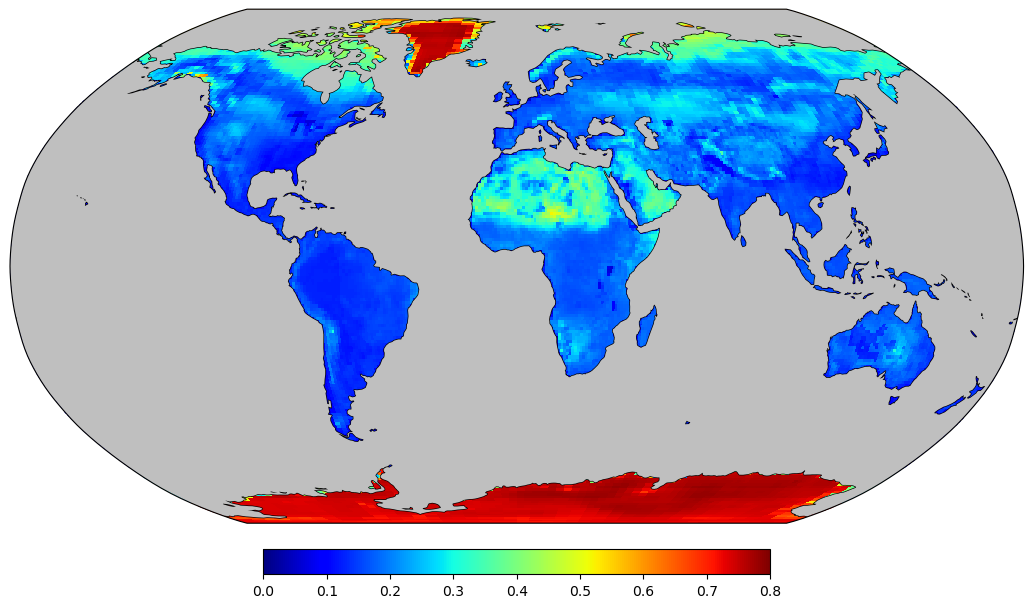

In [205]:
quick_map(annual_original.mean(dim='year')[attributes['out_var']], 'jet', 0.0, 0.8)

In [206]:
global_mean = analysis.area_mean(annual_original[attributes["out_var"]].mean(dim='year'), 
                        ilamb.evaluate_conversion_factor(attributes["area_conversion_factor"]), 
                        ilamb_dat['land_area']).to_dataset(name=f"{attributes['out_var']}_global")

monthly_mean = ilamb.get_monthly_ds(
    ilamb_dat[attributes["in_var"]],
    f"{attributes['out_var']}_monthly",
    ilamb.evaluate_conversion_factor(attributes["time_conversion_factor"]),
    metadata
)
monthly_mean['land_area'] = ilamb_dat.landfrac*ilamb_dat.cell_area

# get climatology
climatology_ds = ilamb.get_ilamb_climatology(
    monthly_mean,
    attributes["out_var"],
    ilamb.evaluate_conversion_factor(attributes["area_conversion_factor"]),
)

In [207]:
global_mean[f"{attributes['out_var']}_global"].values

array(0.19345396)

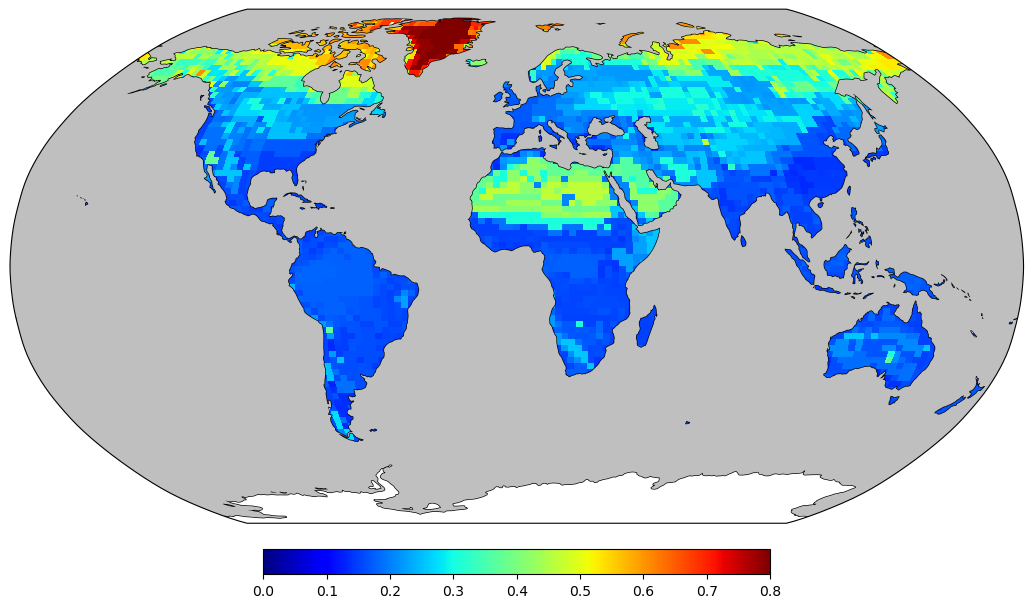

In [193]:
quick_map(da, 'jet', vmin=0.0, vmax=0.8)

In [228]:
fsds = fates_gswp3['FSDS']
fsr = fates_gswp3['FSR']
glob_fsds = analysis.global_from_sparse(sparse_grid, fsds, fates_gswp3)
glob_fsr = analysis.global_from_sparse(sparse_grid, fsr, fates_gswp3)
# da = fates_glob_gswp3[var]
# diff = da - annual_ds.mean(dim='year')[attributes['out_var']]
# quick_map(diff, 'RdBu_r', vmin=-0.1, vmax=0.1)

In [229]:
#rsds = glob_fsds.where(glob_fsds >= 10)
#rsus = glob_fsr.where(glob_fsds >= 10)

In [234]:
glob_da_rsds = analysis.calculate_annual_mean(glob_fsds, None).mean(dim='year')
glob_da_rsus = analysis.calculate_annual_mean(glob_fsr, None).mean(dim='year')

In [235]:
rsds = glob_da_rsds.where(glob_da_rsds >= 10)
rsus = glob_da_rsus.where(glob_da_rsds >= 10)

In [236]:
alb = rsus/rsds

In [239]:
fsr

<xarray.DataArray 'FSR' (time: 192, gridcell: 400)>
dask.array<getitem, shape=(192, 400), dtype=float32, chunksize=(60, 400), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 00:00:00 ... 2015-12-01 00:00:00
  * gridcell  (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
Attributes:
    long_name:      reflected solar radiation
    units:          W/m^2
    cell_methods:   time: mean
    landunit_mask:  unknown

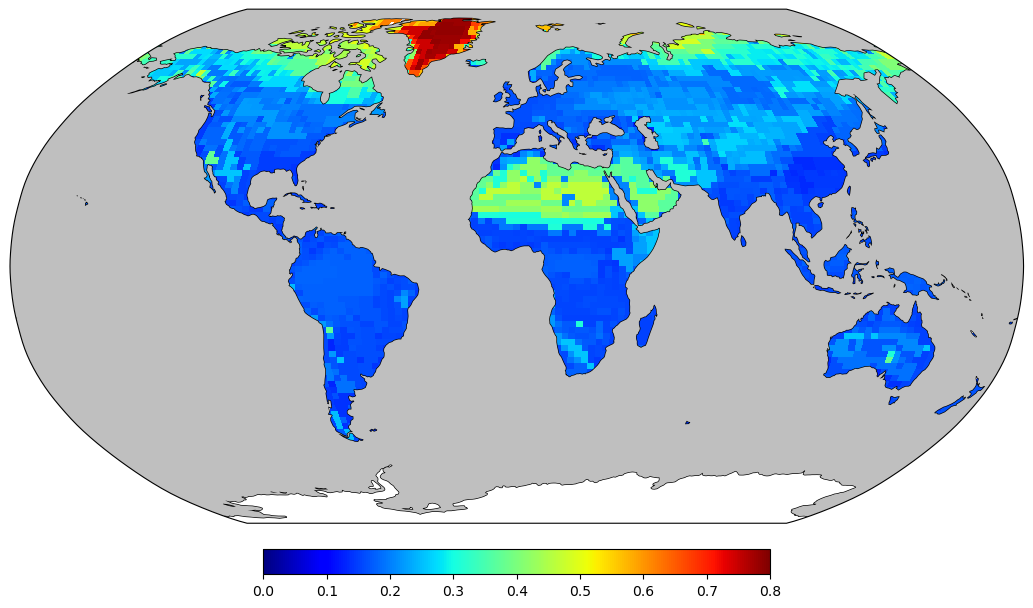

In [237]:
quick_map(alb, 'jet', vmin=0.0, vmax=0.8)

### Zonal Means
Calculate zonal means (by latitude)

In [151]:
# zonal means
fates_zonal_gswp3 = analysis.apply_to_vars(fates_glob_gswp3, out_vars,
                                         func=analysis.calculate_zonal_mean,
                                         add_sparse=False,
                                         land_area=target_grid.land_area,
                                         conversion_factor={var: var_dict[var]["area_conversion_factor"] for var in out_vars})

fates_zonal_crujra = analysis.apply_to_vars(fates_glob_crujra, out_vars,
                                         func=analysis.calculate_zonal_mean,
                                         add_sparse=False,
                                         land_area=target_grid.land_area,
                                         conversion_factor={var: var_dict[var]["area_conversion_factor"] for var in out_vars})

### Climatology
Calculate climatology

In [152]:
# area means from monthly
fates_clim_gswp3 = analysis.get_sparse_area_means(fates_gswp3_monthmeans, 'global',
                                                out_vars, var_dict, land_area,
                                                fates_gswp3.biome)

fates_clim_crujra = analysis.get_sparse_area_means(fates_crujra_monthmeans, 'global',
                                                out_vars, var_dict, land_area,
                                                fates_crujra.biome)

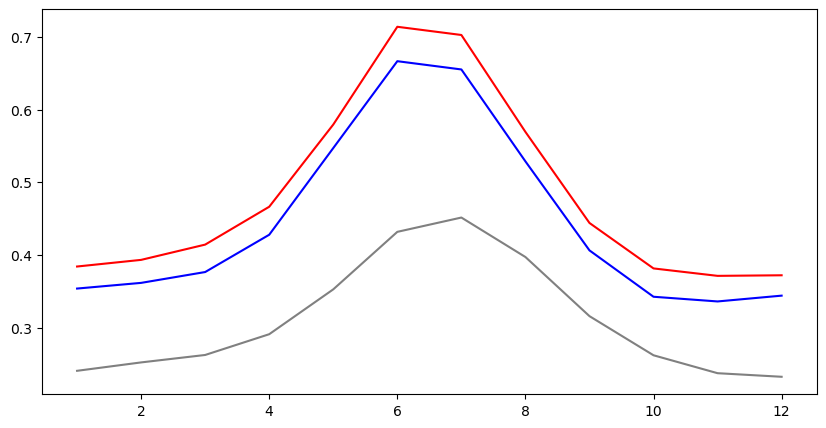

In [179]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(fates_clim_crujra.month, fates_clim_crujra[var], label='GSWP3', c='red')
ax.plot(fates_clim_gswp3.month, fates_clim_gswp3[var], label='CRUJRA', c='blue')
ax.plot(climatology_ds.month, climatology_ds['gpp_cycle'], label='obs', c='gray')

### Calculate Global Annual Values

Area-weighted averages

In [154]:
# sparse area means
fates_areameans_gswp3 = analysis.get_sparse_area_means(fates_gswp3_annmeans,
                                            'global', out_vars,
                                            var_dict, land_area, fates_gswp3.biome)

fates_areameans_crujra = analysis.get_sparse_area_means(fates_crujra_annmeans,
                                            'global', out_vars,
                                            var_dict, land_area, fates_crujra.biome)

In [157]:
fates_areameans_crujra.GPP.values

array(176.42498616)

## CRU-JRA vs. GSWP3
### Annual Maps

In [ ]:
var = 'Temp'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'RH2M'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'Precip'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'GPP'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'EFLX_LH_TOT'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'FSH'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'EF'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'ASA'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'SOILWATER_10CM'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'BTRANMN'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

### Zonal Means

In [ ]:
var_name = 'GPP'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'ASA'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'EFLX_LH_TOT'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'FSH'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'EF'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'SOILWATER_10CM'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'BTRANMN'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

### Climatology

In [ ]:
var = 'GPP'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'EFLX_LH_TOT'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'FSH'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'EF'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'ASA'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'SOILWATER_10CM'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'BTRANMN'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

### Global Annual Values

In [ ]:
summary_df = plotting.summarize_differences(fates_areameans_gswp3, fates_areameans_crujra,
                                            'GSWP3', 'CRU-JRA', var_dict)

In [ ]:
plotting.plot_heatmap(summary_df)

## Observational Comparisons
### Annual Maps

In [ ]:
var = 'GPP'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_crujra, ilamb_var, target_grid.landfrac, var,
                             var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'LAI'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_crujra, ilamb_var, target_grid.landfrac, var,
                             var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'ASA'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_crujra, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'EFLX_LH_TOT'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_crujra, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'FSH'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_crujra, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'EF'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_gswp3, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

In [ ]:
dat = ilamb_var.sel(model='FLUXCOM')

In [ ]:
mod = fates_glob_gswp3.EF*target_grid.landfrac

In [ ]:
(mod - dat).plot(vmax=0.5, vmin=-0.3, cmap='RdBu_r')

In [ ]:
mod.plot(vmin=0, vmax=0.9, cmap='Greens')

### Zonal Means

In [ ]:
var_name = 'GPP'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var_name]['var'], ilamb_config[var_name]['models'])
plotting.plot_model_obs_zonal_diff(ilamb_var, fates_zonal_crujra[var_name], ilamb_obs.land_area,
                          ilamb_config[var_name]['conversion_factor'],
                          var_name, var_name, var_dict[var]['global_units'])

In [ ]:
var_name = 'LAI'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var_name]['var'], ilamb_config[var_name]['models'])
plotting.plot_model_obs_zonal_diff(ilamb_var, fates_zonal_crujra[var_name], ilamb_obs.land_area,
                          ilamb_config[var_name]['conversion_factor'],
                          var_name, var_name, var_dict[var]['global_units'])

In [ ]:
var_name = 'EFLX_LH_TOT'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var_name]['var'], ilamb_config[var_name]['models'])
plotting.plot_model_obs_zonal_diff(ilamb_var, fates_zonal_crujra[var_name], ilamb_obs.land_area,
                          ilamb_config[var_name]['conversion_factor'],
                          var_name, var_name, var_dict[var]['global_units'])

In [ ]:
var_name = 'FSH'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var_name]['var'], ilamb_config[var_name]['models'])
plotting.plot_model_obs_zonal_diff(ilamb_var, fates_zonal_crujra[var_name], ilamb_obs.land_area,
                          ilamb_config[var_name]['conversion_factor'],
                          var_name, var_name, var_dict[var]['global_units'])

In [ ]:
var_name = 'EF'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var_name]['var'], ilamb_config[var_name]['models'])
plotting.plot_model_obs_zonal_diff(ilamb_var, fates_zonal_crujra[var_name], ilamb_obs.land_area, ilamb_config[var_name]['conversion_factor'],
                          var_name, var_name, var_dict[var]['global_units'])

### Climatology

In [ ]:
var_name = 'GPP'
ilamb_var = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_cycle", ilamb_config[var_name]['models'])
plotting.plot_model_obs_climatology_diff(ilamb_var, fates_clim_crujra[var_name], var_name, var_name, var_dict[var_name]['global_units'])

In [ ]:
var_name = 'EFLX_LH_TOT'
ilamb_var = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_cycle", ilamb_config[var_name]['models'])
plotting.plot_model_obs_climatology_diff(ilamb_var, fates_clim_crujra[var_name], var_name, var_name, var_dict[var_name]['global_units'])

In [ ]:
var_name = 'FSH'
ilamb_var = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_cycle", ilamb_config[var_name]['models'])
plotting.plot_model_obs_climatology_diff(ilamb_var, fates_clim_crujra[var_name], var_name, var_name, var_dict[var_name]['global_units'])

In [ ]:
var_name = 'EF'
ilamb_var = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_cycle", ilamb_config[var_name]['models'])
plotting.plot_model_obs_climatology_diff(ilamb_var, fates_clim_gswp3[var_name], var_name, var_name, var_dict[var_name]['global_units'])

### Global Annual Values

In [ ]:
ds_out = xr.Dataset()
for var_name in [var for var in out_vars if var not in ['SOILWATER_10CM', 'BTRANMN', 'TV', 'Temp', 'Precip', 'RH2M']]:
    global_vals = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_global", ilamb_config[var_name]['models'])
    ds_out[var_name] = global_vals.mean(dim='model')

In [ ]:
summary_df = plotting.summarize_differences(ds_out, fates_areameans_crujra, 'ILAMB', 'CRU-JRA', var_dict)
plotting.plot_heatmap(summary_df)